#When can I drink my tea?

This analysis makes use of a vensim model of a teacup to understand how the temperature of tea changes over time, and to understand how external factors such as the temperature of a room influence the timeseries behavior.

In [1]:
import pysd
from imp import reload
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
reload(pysd)
model = pysd.read_vensim('Teacup.mdl')

Our model simulates [Newton's Law of Cooling](http://www.ugrad.math.ubc.ca/coursedoc/math100/notes/diffeqs/cool.html), which follows the functional form:
$$\frac{dT}{dt} = k(T - T_{ambient})$$

In [2]:
stocks = model.run()
stocks.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

/home/danito/ambientes/py2_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


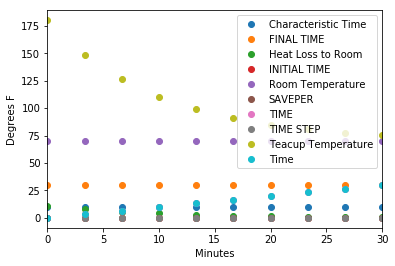

In [30]:
plt.figure(figsize = (6,2))
stocks = model.run(return_timestamps=list(np.linspace(0, 30, 10)))
stocks.ix[:,:].plot(linewidth=0, marker='o')
plt.ylabel('Degrees F')
plt.xlabel('Minutes')
plt.show()

In [15]:
stocks.ix[:,['Teacup Temperature']].to_csv('../../tp1/datos/sd_teacup.csv')

In [16]:
plt.figure(figsize=(6,2))
values = model.run(return_columns=['teacup_temperature', 'room_temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

In [38]:
stocks.head(5)

,Characteristic Time,FINAL TIME,Heat Loss to Room,INITIAL TIME,Room Temperature,SAVEPER,TIME,TIME STEP,Teacup Temperature,Time
0.0,10,30,11.000000,0,70,0.125,0.0,0.125,180.000000,0.0
1.0,10,30,9.946940,0,70,0.125,1.0,0.125,169.469405,1.0
3.0,10,30,8.133607,0,70,0.125,3.0,0.125,151.336071,3.0
7.0,10,30,5.438392,0,70,0.125,7.0,0.125,124.383922,7.0
9.5,10,30,4.228756,0,70,0.125,9.5,0.125,112.287559,9.5


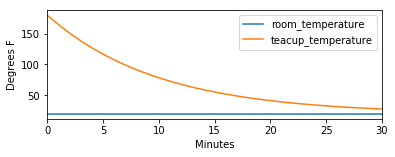

In [39]:
model.components.room_temperature = lambda: 20

plt.figure(figsize(6,2))
values = model.run(return_columns=['teacup_temperature', 'room_temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

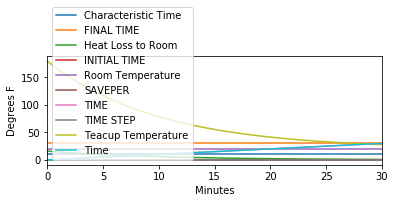

In [40]:

plt.figure(figsize(6,2))
values = model.run(params={'room_temperature':20})
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

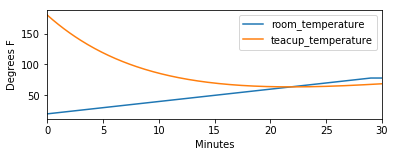

In [41]:
plt.figure(figsize(6,2))
temp_timeseries = pd.Series(index=range(30), data=range(20,80,2))
values = model.run(params={'room_temperature':temp_timeseries},return_columns=['teacup_temperature', 'room_temperature'])
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

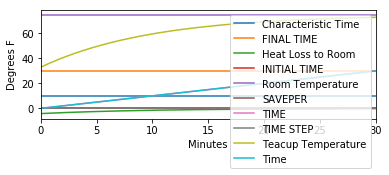

In [42]:
values = model.run(params={'room_temperature':75})
values = model.run(initial_condition=(0, {'teacup_temperature':33}))
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

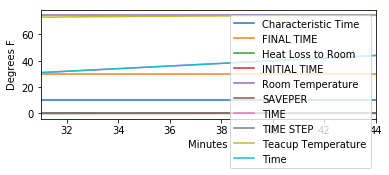

In [43]:
values = model.run(initial_condition='current', return_timestamps=range(31,45))
values.plot()
plt.ylabel('Degrees F')
plt.xlabel('Minutes');

In [44]:
#generate a dataset from the model to fit our regression to

X_training = []
Y_training = []
for room_temp in np.random.uniform(60, 80, size=20):
    for tea_temp in np.random.uniform(60, 200, size=200):
        X_training.append([room_temp, tea_temp])
        model.set_components(params={'room_temperature':room_temp})
        #model.components.state['teacup_temperature'] = tea_temp
        Y_training.append(model.components.heat_loss_to_room())

In [45]:
from sklearn.svm import SVR

regression = SVR()
regression.fit(X_training, Y_training)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [52]:
regression.predict(np.array([66, 40]).reshape(1,-1))

array([ 0.35022713])

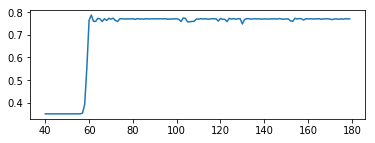

In [53]:
plt.plot(range(40, 180), [regression.predict(np.array([66, teatemp]).reshape(1,-1)) for teatemp in range(40, 180)])

In [54]:
def new_heatflow_function():
    """ Replaces the original flowrate equation with a regression model"""
    tea_temp = model.components.teacup_temperature()
    room_temp = model.components.room_temperature()
    return regression.predict(np.array([room_temp, tea_temp]).reshape(1,-1)[0]

model.components.heat_loss_to_room = new_heatflow_function

In [55]:
model.components.heat_loss_to_room()

ValueError: Expected 2D array, got 1D array instead:
array=[ 76.16460388  74.49845489].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [33]:
model.run().plot()

ValueError: Expected 2D array, got 1D array instead:
array=[  70.77211183  180.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [19]:
model.components.teacup_temperature()

74.498454886517038